In [1]:
from __future__ import annotations
import typing
from typing import NewType, Union, Optional, List, Callable
import dataclasses

import metadsl
import metadsl_rewrite
import metadsl_core
import pandas as pd

from toki import datatypes as dts
from toki import types as tt
from toki.backends.core import Backend, BackendTranslator
from toki.viz import visualize

In [2]:
def constructor(fn: Callable):
    """Decorator for expression constructor."""
    def _fn(*args, **kwargs):
        fn.__qualname__ = fn.__qualname__.split('.')[0]
        return metadsl.expression(fn)(*args, **kwargs)
    return _fn


class Expr(metadsl.Expression):
    """Meta expression."""
    
    @property
    def _display_name(self) -> str:
        return self.__class__.__name__
    
    @staticmethod
    def expr(*args, **kwargs):
        """Create an expression with the given value."""
        raise NotImplementedError('Operation not supported yet.')
    
    def __repr__(self) -> str:
        fn_name = self.function if not str(self.function) == 'expr' else self._display_name
            
        output = '{}({})'.format(fn_name, self.args)
        return output


class DataTypeExpr(Expr):
    """Data type expression."""
    
    def __add__(self, other: Union[DataType, int, float]):
        raise NotImplementedError('Operation not supported yet.')

        
class OperationExpr(Expr):
    """Operation expression."""


class IntegerExpr(DataTypeExpr):
    """String expression."""
    
    @staticmethod
    @constructor
    def expr(value: int) -> IntegerExpr:
        """Create an IntegerExpr expression with the given value."""
    
    @property
    def value(self) -> int:
        return self.args[0]
    
    
class Add(OperationExpr):
    """Binary ``add`` operation."""
    
    @property
    def left(self) -> DataTypeExpr:
        return self.args[0]
    
    @property
    def right(self) -> DataTypeExpr:
        return self.args[1]
    
    @staticmethod
    @constructor
    def expr(left: DataTypeExpr, right:DataTypeExpr) -> Add:
        """Create an Add expression for the given parameters."""
    
def register(name, klass, f_source_name, f_target):
    f_target.__qualname__ = name
    setattr(klass, f_source_name, metadsl.expression(f_target))
    

def _integer_add(x: Union[int, IntegerExpr], y: Union[int, IntegerExpr]) -> Add:
    """Dispatch for addition between two integers."""

    
register('Add', IntegerExpr, '__add__', _integer_add)
IntegerExpr.__add__ = metadsl.expression(_integer_add)
i = IntegerExpr.expr(1)
expr_add = Add.expr(i, i)
print(i)
print(expr_add)
print(i + i)

IntegerExpr(1)
Add(IntegerExpr(1), IntegerExpr(1))
Add(IntegerExpr(1), IntegerExpr(1))


In [3]:
sch = tt.TableSchema.expr({
    'col_1': {'type': 'int64', 'nullable': True},
    'col_2': {'type': 'float64', 'nullable': True},
})

print(sch)

TableSchema
  col_1: int64(nullale)
  col_2: float64(nullale)



In [4]:
type(sch.function)

metadsl.typing_tools.Infer

In [5]:
table = tt.Table.expr(
    'my_table', 
    sch, 
    database_name='postgres', 
    database_schema_name='public'
)
table

postgres.public.my_table: Table
  col_1: int64(nullale)
  col_2: float64(nullale)

In [6]:
expr = table[['col_1', 'col_2']]
expr

Projection[['col_1', 'col_2']]
  postgres.public.my_table: Table
    col_1: int64(nullale)
    col_2: float64(nullale)
  

In [7]:
import stackeddag.core as sd

In [8]:
import pydot
import stackeddag.core as sd

def graph2ascii(graph) -> str:
    v = pydot.graph_from_dot_data(str(graph))
    g = v[0]
    edges = g.get_edges()
    nodes = g.get_nodes()
    la = []
    for i in nodes:
        attr = i.get_attributes()
        if 'label' in attr:
            name = i.get_name()
            label = attr['label']
            if label.startswith('"'):
                label = label[1:]
            if label.endswith('"'):
                label = label[:-1]
            la.append((name, label))
    ed = []
    for i in edges:
        src = i.get_source()
        dst = i.get_destination()
        ed.append((src, [dst]))
    return sd.edgesToText(sd.mkLabels(la), sd.mkEdges(ed))

In [9]:
import graphviz as gv
from uuid import uuid4


def expr_to_graph(expr: tt.Expr) -> gv.Digraph:
    g = gv.Digraph(comment='Graph')
    g.attr('node', shape='box', rankdir='BT')
    
    edges = []

    nodes = [expr]
    parent = None
    while len(nodes):
        node = nodes.pop(0)
        node_id = str(id(node))
        g.node(node_id, '{}.{}'.format(node._display_name, node.function))
        if parent:
            edges.append((node_id, parent[0]))
        parent = (node_id, node)
        
        for i in node.args:
            if isinstance(i, tt.Expr):
                nodes.append(i)
            else:
                item_id = uuid4().hex
                if isinstance(i, dict):
                    for k, v in i.items():
                        item_id = str(id(k))
                        item_val = '{}:{}'.format(k, v)
                        g.node(item_id, item_val)
                        edges.append((item_id, node_id))
                else:
                    item_val = str(i)
                    g.node(item_id, item_val)
                    edges.append((item_id, node_id))
                

    g.edges(edges)
    return g
    
graph0 = expr_to_graph(expr)
print(graph2ascii(graph0), end="")

o o    col_{1:{'type': 'int64', 'nullable': True},2:{'type': 'float64', 'nullable': True}}
|/
o o o o    TableSchema.expr,my_table,postgres,public
|/_/_/
o o    postgres.public.my_table.expr,['col_1', 'col_2']
|/
o    Projection[['col_1', 'col_2']].Table._get_columns


In [10]:
new_expr = (((((expr + 1) - 1) * 3) / 2) ** 2) % 2
new_expr

__mod__([__pow__([__truediv__([__mul__([__sub__([__add__([Projection[['col_1', 'col_2']]
  postgres.public.my_table: Table
    col_1: int64(nullale)
    col_2: float64(nullale)
  
, 1]), 1]), 3]), 2]), 2]), 2])

In [11]:
graph1 = expr_to_graph(new_expr)
print(str(graph1))
print(graph2ascii(graph1))

// Graph
digraph {
	node [rankdir=BT shape=box]
	140617289829104 [label="TableBase.TableBase.__mod__"]
	bca7c3272282428ca5b881b64ebd5d74 [label=2]
	140617289829488 [label="TableBase.TableBase.__pow__"]
	"5e3cdcdbbb69418ca6e34879f8daeefb" [label=2]
	140617496054704 [label="TableBase.TableBase.__truediv__"]
	"938bf09f64434103a5565eb39a454b76" [label=2]
	140617496054176 [label="TableBase.TableBase.__mul__"]
	b195dd90127d426ca9aac7ba10204869 [label=3]
	140617968981136 [label="TableBase.TableBase.__sub__"]
	"517b7729d3ac441a83e41b523d26fd12" [label=1]
	140617968981520 [label="TableBase.Projection.__add__"]
	"82b6a077725241ce9397c0871e5c6c06" [label=1]
	140617290147728 [label="Projection[['col_1', 'col_2']].Table._get_columns"]
	d8fe95db9ff44a3f9f5c4c5557d33b9f [label="['col_1', 'col_2']"]
	140617290146624 [label="postgres.public.my_table.expr"]
	b2c9a60ebe644e2281f64d7d9444d7fa [label=my_table]
	"55ee6223dcf1491d8b6c8fd37fee9e77" [label=postgres]
	"7c79561aa8a1481389693a3afdad5a14" [label=p

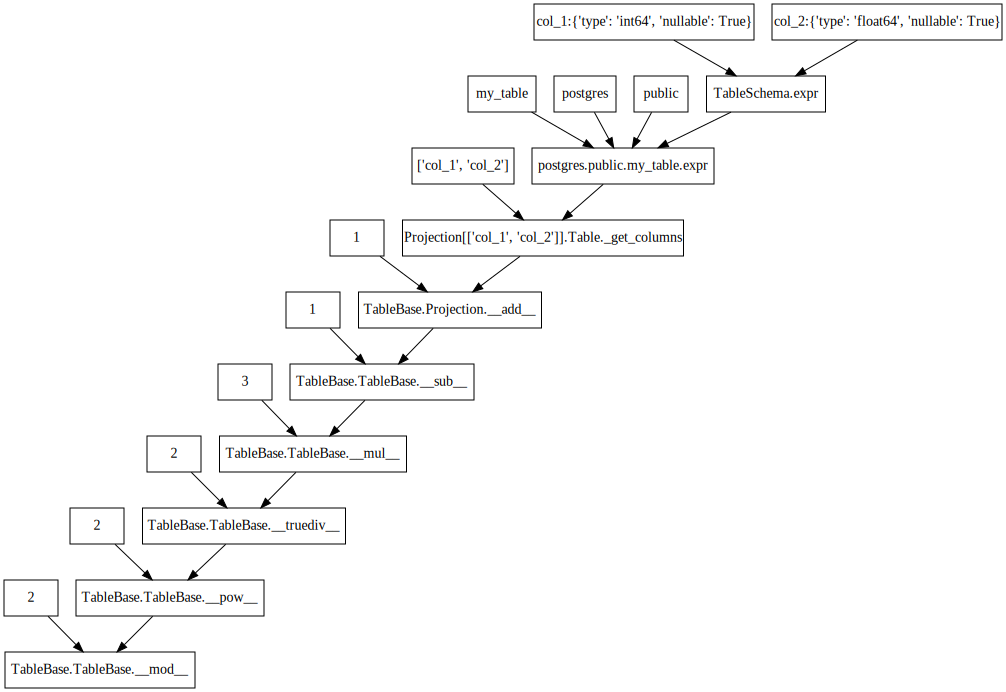

In [12]:
graph1